<a href="https://colab.research.google.com/github/ayushi-2104/Streamlit/blob/main/docs/tutorials/python/Predict%20engagement%20and%20emotions%20on%20video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict engagement and emotions on video with Python interface of EmotiEffLib

The first GPU device should be used for cuda

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


Function to download test data downloader:

In [2]:
import os
import urllib.request



def get_test_data_downloader(test_dir):
    input_file = os.path.join(test_dir, "download_test_data.sh")
    if os.path.isfile(input_file):
        return input_file
    url = "https://github.com/sb-ai-lab/EmotiEffLib/blob/main/tests/download_test_data.sh?raw=true"
    print("Downloading download_test_data.sh from", url)
    input_file = "download_test_data.sh"
    if os.path.isfile(input_file):
        return input_file
    urllib.request.urlretrieve(url, input_file)
    return input_file

Check if it runs under colab and install dependencies:

In [ ]:
try:
    import google.colab
    IN_COLAB = True
    urllib.request.urlretrieve("https://github.com/sb-ai-lab/EmotiEffLib/blob/main/docs/tutorials/python/requirements.txt?raw=true", "requirements.txt")
    !pip install -r requirements.txt
except:
    IN_COLAB = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823

Download test data:

In [ ]:
from google.colab import files
print("Please upload your video file:")
uploaded = files.upload()
input_file = next(iter(uploaded))

Please upload your video file:


Saving WhatsApp Video 2025-04-06 at 21.31.15_36fcf444.mp4 to WhatsApp Video 2025-04-06 at 21.31.15_36fcf444.mp4


Function for faces recognition:

In [ ]:
from typing import List
import numpy as np

def recognize_faces(frame: np.ndarray, device: str) -> List[np.array]:
    """
    Detects faces in the given image and returns the facial images cropped from the original.

    This function reads an image from the specified path, detects faces using the MTCNN
    face detection model, and returns a list of cropped face images.

    Args:
        frame (numpy.ndarray): The image frame in which faces need to be detected.
        device (str): The device to run the MTCNN face detection model on, e.g., 'cpu' or 'cuda'.

    Returns:
        list: A list of numpy arrays, representing a cropped face image from the original image.

    Example:
        faces = recognize_faces('image.jpg', 'cuda')
        # faces contains the cropped face images detected in 'image.jpg'.
    """

    def detect_face(frame: np.ndarray):
        mtcnn = MTCNN(keep_all=False, post_process=False, min_face_size=40, device=device)
        bounding_boxes, probs = mtcnn.detect(frame, landmarks=False)
        if probs[0] is None:
            return []
        bounding_boxes = bounding_boxes[probs > 0.9]
        return bounding_boxes

    bounding_boxes = detect_face(frame)
    facial_images = []
    for bbox in bounding_boxes:
        box = bbox.astype(int)
        x1, y1, x2, y2 = box[0:4]
        facial_images.append(frame[y1:y2, x1:x2, :])
    return facial_images

## EmotiEffLib with ONNX

Install EmotiEffLib with ONNX support:

In [ ]:
!pip install emotiefflib[engagement]

Import libraries:

In [ ]:
import os
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch import MTCNN
from emotiefflib.facial_analysis import EmotiEffLibRecognizer, get_model_list

Path to the directory with test data, select device and model:

In [ ]:
test_dir = "data"
device = "cpu"
model_name = get_model_list()[0]

### Read video and recognize engagement:

For engagement recognition, we need to collect a sequence of video frames before predicting engagement class. To avoid extracting visual features for the same frames in different sliding windows, it is better to read the whole video before recognizing engagement or extract visual features for each frame before passing them to classifier.

Read the whole video:

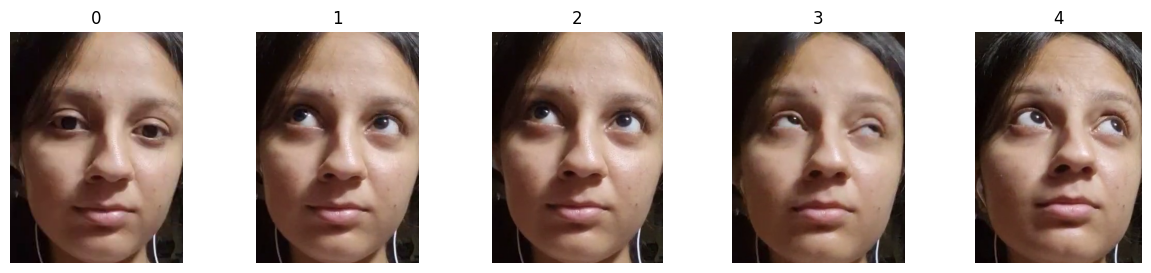

In [ ]:
input_file = next(iter(uploaded))

all_frames = []
# Create a row of 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
i = 0

# Read the whole video
cap = cv2.VideoCapture(input_file)
while cap.isOpened():
    success, image = cap.read()
    if not success:
        break

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    facial_images = recognize_faces(image_rgb, device)
    if len(facial_images) == 0:
        continue
    all_frames += facial_images
    # Draw each 10th frame
    if i % 10 == 0 and i // 10 < 5:
        idx = i // 10
        axes[idx].imshow(facial_images[0])
        axes[idx].set_title(idx)
        axes[idx].axis('off')
    i += 1

cap.release()

In [ ]:
!pip install emotiefflib[engagement] # Make sure the library is installed with ONNX support.
from emotiefflib.facial_analysis import EmotiEffLibRecognizer, get_model_list
# Import necessary libraries
#Import the EmotiEffLibRecognizer class from the correct module.
from emotiefflib.facial_analysis import get_model_list
import os
import urllib.request
import cv2
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch import MTCNN
from typing import List
from google.colab import files
import torch


# Function to download test data downloader:
def get_test_data_downloader(test_dir):
    input_file = os.path.join(test_dir, "download_test_data.sh")
    if os.path.isfile(input_file):
        return input_file
    url = "https://github.com/sb-ai-lab/EmotiEffLib/blob/main/tests/download_test_data.sh?raw=true"
    print("Downloading download_test_data.sh from", url)
    input_file = "download_test_data.sh"
    if os.path.isfile(input_file):
        return input_file
    urllib.request.urlretrieve(url, input_file)
    return input_file

def recognize_faces(frame: np.ndarray, device: str) -> List[np.array]:
    """
    Detects faces in the given image and returns the facial images cropped from the original.

    This function reads an image from the specified path, detects faces using the MTCNN
    face detection model, and returns a list of cropped face images.

    Args:
        frame (numpy.ndarray): The image frame in which faces need to be detected.
        device (str): The device to run the MTCNN face detection model on, e.g., 'cpu' or 'cuda'.

    Returns:
        list: A list of numpy arrays, representing a cropped face image from the original image.

    Example:
        faces = recognize_faces('image.jpg', 'cuda')
        # faces contains the cropped face images detected in 'image.jpg'.
    """

    def detect_face(frame: np.ndarray):
        mtcnn = MTCNN(keep_all=False, post_process=False, min_face_size=40, device=device)
        bounding_boxes, probs = mtcnn.detect(frame, landmarks=False)
        if probs[0] is None:
            return []
        bounding_boxes = bounding_boxes[probs > 0.9]
        return bounding_boxes

    bounding_boxes = detect_face(frame)
    facial_images = []
    for bbox in bounding_boxes:
        box = bbox.astype(int)
        x1, y1, x2, y2 = box[0:4]
        facial_images.append(frame[y1:y2, x1:x2, :])
    return facial_images


# Explicitly set device to 'cpu' to avoid potential CUDA issues
device = "cpu"  # Or "cuda" if you have a CUDA-enabled GPU and it's properly configured
model_name = get_model_list()[0]
sliding_window_size = 128
fer = EmotiEffLibRecognizer(engine="onnx", model_name=model_name, device=device)

print("Please upload your video file:")
uploaded = files.upload()
input_file = next(iter(uploaded))

# Process the video frame-by-frame
cap = cv2.VideoCapture(input_file)
all_frames = []  # Store all frames with detected faces

while cap.isOpened():
    success, image = cap.read()
    if not success:
        break

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    facial_images = recognize_faces(image_rgb, device)

    if len(facial_images) > 0:
        all_frames.extend(facial_images)  # Accumulate all frames

cap.release()

# Check if enough frames were collected
if len(all_frames) >= sliding_window_size:
    # Process all frames together if enough frames were collected
    _, scores = fer.predict_engagement(all_frames, sliding_window_size)
    score = np.mean(scores, axis=0)
    engagement_idx = np.argmax(score)
    print(f"Predicted Engagement Class: {fer.idx_to_engagement_class[engagement_idx]}")
else:
    print(f"Not enough frames to predict engagement. Required: {sliding_window_size}, Found: {len(all_frames)}")

Please upload your video file:


Saving WhatsApp Video 2025-04-06 at 21.31.15_36fcf444.mp4 to WhatsApp Video 2025-04-06 at 21.31.15_36fcf444 (1).mp4
Predicted Engagement Class: Distracted


Recognize engagement using `predict_engagement` method:

### Recognize engagement and emotions on a sequence of frames by calling features extractor and classifier separately

In [ ]:
features = fer.extract_features(all_frames)
_, emotion_scores = fer.classify_emotions(features, logits=True)
_, engagement_scores = fer.classify_engagement(features)
emotion_score = np.mean(emotion_scores, axis=0)
engagement_score = np.mean(engagement_scores, axis=0)
emotion_idx = np.argmax(emotion_score)
engagement_idx = np.argmax(engagement_score)

# Print the predicted emotion instead of using assert
print(f"Predicted Emotion: {fer.idx_to_emotion_class[emotion_idx]}")
print(f"Predicted Engagement: {fer.idx_to_engagement_class[engagement_idx]}")

# Instead of asserting a specific emotion, check if the prediction is within the expected range
# For example, if you expect the emotion to be either "Sadness" or "Neutral":
# assert fer.idx_to_emotion_class[emotion_idx] in ["Sadness", "Neutral"]

Predicted Emotion: Neutral
Predicted Engagement: Distracted
